In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import Geohash as geo
import gc
from util import *
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
%reload_ext autoreload
%autoreload 2

In [120]:
df = pd.read_csv('data/traffic-management.zip', compression='zip')

In [121]:
df_train = get_train_data(df)

In [122]:
df_train.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
4,qp090q,15,4:0,0.074468
5,qp03tu,1,12:15,0.023843


In [123]:
df_train = fill_missing_timeframe(df_train)

/home/arie/external/aiforsea-x/util.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['day_timestamp'] = df.day.map(str) + ':' + df.timestamp

100%|██████████| 1307/1307 [09:47<00:00,  1.49it/s]


In [125]:
df_train.to_csv('df_train.csv')

In [3]:
df_train = pd.read_csv('df_train.csv')

In [4]:
df_train = preprocess(df_train)

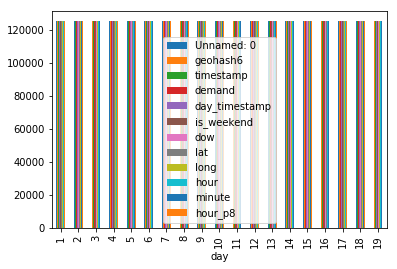

In [5]:
df_train.groupby('day').agg('count').plot.bar()

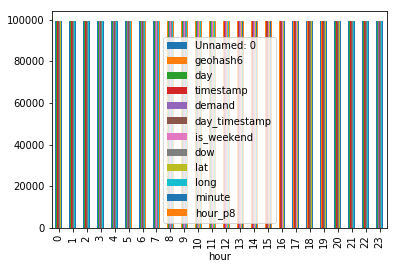

In [6]:
df_train.groupby('hour').agg('count').plot.bar()

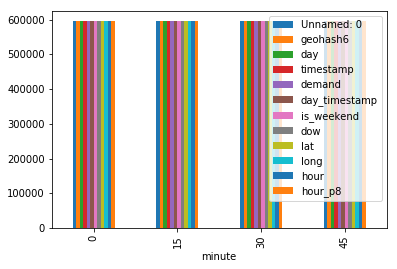

In [7]:
df_train.groupby('minute').agg('count').plot.bar()

# Do The Mean and Median Encoding

## Per Geo

Motivation: 

there are some geos where the ride hailing is high in demand than others, Over all time.

Mean and median are used because there are some chances that mean will be pulled by outliers either in higher times or lower demand times.


In [8]:
df_agg = df_train.groupby(['geohash6']).agg(['mean', 'median'])['demand']
df_train['mean_demand_per_geo'] = df_train['geohash6'].map(df_agg['mean'])
df_train['median_demand_per_geo'] = df_train['geohash6'].map(df_agg['median'])

## Per Geo Per Day of Week
Motivation:
There are some repeating pattern in day of week

In [9]:
df_train['mean_demand_per_gdow'] = df_train.groupby(['geohash6', 'dow'])['demand'].transform('mean')
df_train['median_demand_per_gdow'] = df_train.groupby(['geohash6', 'dow'])['demand'].transform('median')

In [10]:
df_train['mean_demand_per_gdowh'] = df_train.groupby(['geohash6', 'dow', 'hour'])['demand'].transform('mean')
df_train['median_demand_per_gdowh'] = df_train.groupby(['geohash6', 'dow', 'hour'])['demand'].transform('median')

In [11]:
df_train.head()

,Unnamed: 0,geohash6,day,timestamp,demand,day_timestamp,is_weekend,dow,lat,long,hour,minute,hour_p8,mean_demand_per_geo,median_demand_per_geo,mean_demand_per_gdow,median_demand_per_gdow,mean_demand_per_gdowh,median_demand_per_gdowh
0,0,qp03wc,18,20:0,0.020072,18:20:0,False,5,-5.353088,90.653687,20,0,4,0.296303,0.244792,0.367113,0.263697,0.044151,0.042226
1,1,qp03pn,10,14:30,0.024721,10:14:30,False,4,-5.413513,90.664673,14,30,22,0.031988,0.015595,0.043346,0.032563,0.019996,0.020734
2,2,qp09sw,9,6:15,0.102821,9:6:15,False,3,-5.325623,90.906372,6,15,14,0.094756,0.090670,0.101790,0.094682,0.157714,0.167262
3,3,qp090q,15,4:0,0.074468,15:4:0,False,2,-5.413513,90.719604,4,0,12,0.022575,0.019755,0.021842,0.017717,0.038561,0.038928
4,4,qp03tu,1,12:15,0.023843,1:12:15,False,2,-5.336609,90.609741,12,15,20,0.020902,0.019254,0.020439,0.019635,0.019795,0.022780


# Lagging Demand Features

Motivation:

Time series data has autocorrelation, which basically says that the data at time $t$ has some dependency on time $t-x$

## Lag $t-1$  Features

need to sort the values by places and time before we do the preprocessing

In [12]:
df_train['demand_tmin1'] = generate_demand_lag_feature(df_train, 1)

In [13]:
df_train[
    df_train.demand_tmin1 >= 0
].head()

,Unnamed: 0,geohash6,day,timestamp,demand,day_timestamp,is_weekend,dow,lat,long,hour,minute,hour_p8,mean_demand_per_geo,median_demand_per_geo,mean_demand_per_gdow,median_demand_per_gdow,mean_demand_per_gdowh,median_demand_per_gdowh,demand_tmin1
25,25,qp06n8,16,5:30,0.002909,16:5:30,False,3,-5.270691,90.642700,5,30,13,0.005072,0.000000,0.003747,0.000000,0.006237,0.005379,0.012421
27,27,qp03wp,18,6:30,0.040687,18:6:30,False,5,-5.320129,90.620728,6,30,14,0.017336,0.014231,0.017205,0.015317,0.030358,0.024590,0.026395
72,72,qp0dj0,8,5:45,0.250478,8:5:45,False,2,-5.270691,90.928345,5,45,13,0.140727,0.122350,0.153904,0.143673,0.186786,0.187484,0.083083
99,99,qp09bh,7,3:0,0.181012,7:3:0,False,1,-5.292664,90.708618,3,0,11,0.185171,0.189978,0.188337,0.192935,0.193400,0.195378,0.173506
111,111,qp09dk,17,22:45,0.127262,17:22:45,False,4,-5.336609,90.807495,22,45,6,0.167753,0.158174,0.153008,0.141243,0.101194,0.093704,0.218540


## Lag $t - 1$ Hour Feature

In [14]:
df_train['demand_tmin4'] = generate_demand_lag_feature(df_train, 4)
df_train[
    df_train.demand_tmin4 >= 0
].head()

,Unnamed: 0,geohash6,day,timestamp,demand,day_timestamp,is_weekend,dow,lat,long,...,minute,hour_p8,mean_demand_per_geo,median_demand_per_geo,mean_demand_per_gdow,median_demand_per_gdow,mean_demand_per_gdowh,median_demand_per_gdowh,demand_tmin1,demand_tmin4
648,648,qp097d,6,8:30,0.034349,6:8:30,True,0,-5.391541,90.862427,...,30,16,0.026811,0.018558,0.022450,0.016875,0.021430,0.015904,0.063388,0.005610
841,841,qp09bn,18,0:0,0.056127,18:0:0,False,5,-5.281677,90.708618,...,0,8,0.041023,0.040741,0.042148,0.042234,0.075141,0.079338,0.069258,0.034261
865,865,qp09t8,11,7:30,0.138611,11:7:30,False,5,-5.358582,90.950317,...,30,15,0.098828,0.080234,0.101948,0.068290,0.209888,0.213822,0.032514,0.016300
929,929,qp09t8,12,21:30,0.001674,12:21:30,True,6,-5.358582,90.950317,...,30,5,0.098828,0.080234,0.078512,0.073971,0.009723,0.002816,0.138611,0.096502
975,975,qp09uz,14,13:30,0.307621,14:13:30,False,1,-5.276184,90.917358,...,30,21,0.289818,0.251318,0.334543,0.322445,0.313840,0.319287,0.399954,0.613426


## Lag 7 days Features

Motivation:

weekly trend might also show significant effect on next week trend

need to shift for 672 timestamps

In [15]:
df_train['demand_tmin672'] = generate_demand_lag_feature(df_train, 672)
df_train[
    df_train.demand_tmin672 >= 0
].head()

,Unnamed: 0,geohash6,day,timestamp,demand,day_timestamp,is_weekend,dow,lat,long,...,hour_p8,mean_demand_per_geo,median_demand_per_geo,mean_demand_per_gdow,median_demand_per_gdow,mean_demand_per_gdowh,median_demand_per_gdowh,demand_tmin1,demand_tmin4,demand_tmin672
443422,443422,qp03r6,10,10:0,0.169532,10:10:0,False,4,-5.391541,90.675659,...,18,0.100602,0.103250,0.110310,0.114336,0.200043,0.204026,0.082894,0.124346,0.111874
444419,444419,qp03r6,4,19:15,0.056264,4:19:15,False,5,-5.391541,90.675659,...,3,0.100602,0.103250,0.109727,0.119737,0.049027,0.047382,0.169532,0.083603,0.137266
444468,444468,qp09fu,3,12:45,0.172025,3:12:45,False,4,-5.292664,90.829468,...,20,0.128136,0.126940,0.124867,0.120821,0.179838,0.182248,0.247683,0.053011,0.112762
445386,445386,qp03zb,14,13:15,0.153688,14:13:15,False,1,-5.314636,90.697632,...,21,0.222485,0.229052,0.198587,0.198725,0.169449,0.174479,0.156126,0.459611,0.049683
445546,445546,qp03zb,6,15:0,0.115248,6:15:0,True,0,-5.314636,90.697632,...,23,0.222485,0.229052,0.165349,0.171324,0.109568,0.111170,0.153688,0.229578,0.225076


## Differencing between lagging feature mean encoded

In [16]:
df_train['mean_enc_demand_tmin1'] = df_train.groupby(['geohash6', 'dow', 'hour'])['demand_tmin1'].transform('mean')
df_train['mean_enc_demand_tmin4'] = df_train.groupby(['geohash6', 'dow', 'hour'])['demand_tmin4'].transform('mean')
df_train['mean_enc_demand_tmin672'] = df_train.groupby(['geohash6', 'dow', 'hour'])['demand_tmin672'].transform('mean')

# Percentile 99 and Percentile 1 per Geo per Day of Week

Motivation:

The model might need a little guide to predict extreme values. Day of week might have repeating pattern and thus the extreme values in day of week might not differ too much.

In [17]:
df_train['demand_gdow_q95'] = df_train.groupby(['geohash6', 'dow'])['demand'].transform(lambda x: x.quantile(.95))
df_train['demand_gdow_q10'] = df_train.groupby(['geohash6', 'dow'])['demand'].transform(lambda x: x.quantile(.1))
df_train['demand_diff_wt_gdow_q95'] = df_train['demand'] - df_train['demand_gdow_q95']
df_train['demand_diff_wt_gdow_q10'] = df_train['demand'] - df_train['demand_gdow_q10']
df_train['mean_demand_diff_wt_gdow_q95'] = df_train.groupby(['geohash6', 'dow'])['demand_diff_wt_gdow_q95'].transform('mean')
df_train['mean_demand_diff_wt_gdow_q10'] = df_train.groupby(['geohash6', 'dow'])['demand_diff_wt_gdow_q10'].transform('mean')

# Clustering Features
Motivation: 

hypothesis: For each geo region and each hour for each dow there exists patterns that could be clustered together 

In [18]:
df_train['median_demand_per_gdowh'] = df_train['median_demand_per_gdowh'].fillna(0)
df_train['mean_demand_per_gdowh'] = df_train['mean_demand_per_gdowh'].fillna(0)

In [19]:
cluster_features = [
    'lat', 'long', 'dow', 'hour'
]
df_cluster = df_train.groupby(cluster_features).agg('mean')[[
    'median_demand_per_gdowh', 'mean_demand_per_gdowh'
]].reset_index()


100%|██████████| 11/11 [00:32<00:00,  3.63s/it]


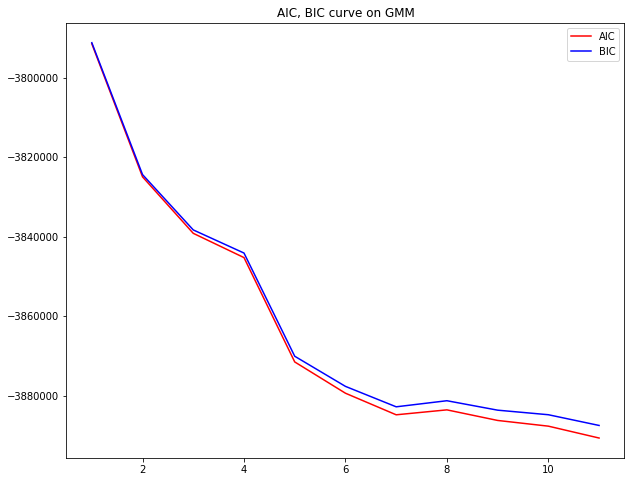

In [229]:
draw_gmm_aic_bic_plot(df_cluster, max_component=12)

It seems that 8 components gives me enough cluster for this sample data (in the graph it says 7, but x scaled from 0 to 12, means I have to +1 from the graph) 

In [20]:
df_train_wt_cluster = add_cluster(
    GaussianMixture(8),
    df_cluster,
    df_train,
    'cluster_gdowh',
    'cluster_prob_gdowh',
    cluster_features
)

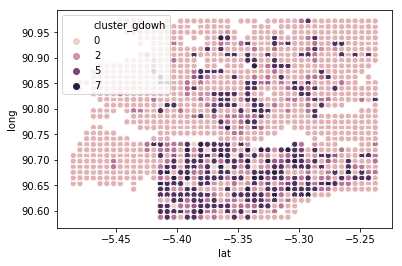

In [241]:
sns.scatterplot(
    x='lat',
    y='long',
    hue='cluster_gdowh',
    data=df_train_wt_cluster
)
plt.show()

# Rolling Features

In [21]:
df_train_wt_cluster = df_train_wt_cluster.sort_values(
    by=['geohash6','day', 'hour', 'minute']
)

In [22]:
df_train_wt_cluster['demand_rolling_4'] = generate_rolling_feature(df_train_wt_cluster, 4)

# Training Step 1 

In [23]:
categorical_features = [
    'is_weekend',
    'dow',
    'hour',
    'cluster_gdowh'
]

numerical_features = [
    'lat',
    'long',
    'minute',
    'mean_demand_per_geo',
    'median_demand_per_geo',
    'mean_demand_per_gdow',
    'median_demand_per_gdow',
    'mean_enc_demand_tmin1',
    'mean_enc_demand_tmin4',
    'mean_enc_demand_tmin672',
    'demand_gdow_q95',
    'demand_gdow_q10',
    'mean_demand_diff_wt_gdow_q95',
    'mean_demand_diff_wt_gdow_q10',
    'cluster_prob_gdowh',
    'demand_rolling_4'
]
target = 'demand'

train_set = get_train_data(df_train_wt_cluster, n_days=14)
test_set  = df_train_wt_cluster.loc[df_train_wt_cluster.index.difference(train_set.index)]

X_train = train_set[categorical_features + numerical_features]
y_train = train_set[target]

In [24]:
cat_indexes = [X_train.columns.get_loc(f) for f in categorical_features]

In [25]:
preprocess = make_column_transformer(
    (categorical_features, SimpleImputer()),
    (numerical_features, SimpleImputer(strategy='constant', fill_value=0))
)
p_cat_tree = make_pipeline(
    preprocess,
    CatBoostRegressor(cat_features=cat_indexes, iterations=100, early_stopping_rounds=100)
)

In [26]:
p_cat_tree.fit(X_train, y_train)

0:	learn: 0.1311208	total: 312ms	remaining: 30.9s
1:	learn: 0.1274081	total: 533ms	remaining: 26.1s
2:	learn: 0.1238007	total: 763ms	remaining: 24.7s
3:	learn: 0.1203056	total: 995ms	remaining: 23.9s
4:	learn: 0.1168991	total: 1.24s	remaining: 23.6s
5:	learn: 0.1135657	total: 1.46s	remaining: 22.9s
6:	learn: 0.1103378	total: 1.69s	remaining: 22.4s
7:	learn: 0.1072313	total: 1.92s	remaining: 22s
8:	learn: 0.1042196	total: 2.18s	remaining: 22s
9:	learn: 0.1012836	total: 2.42s	remaining: 21.8s
10:	learn: 0.0984412	total: 2.66s	remaining: 21.5s
11:	learn: 0.0956748	total: 2.89s	remaining: 21.2s
12:	learn: 0.0930130	total: 3.15s	remaining: 21.1s
13:	learn: 0.0904326	total: 3.37s	remaining: 20.7s
14:	learn: 0.0879184	total: 3.61s	remaining: 20.5s
15:	learn: 0.0854791	total: 3.84s	remaining: 20.2s
16:	learn: 0.0831459	total: 4.09s	remaining: 19.9s
17:	learn: 0.0808661	total: 4.32s	remaining: 19.7s
18:	learn: 0.0786708	total: 4.57s	remaining: 19.5s
19:	learn: 0.0765341	total: 4.82s	remaining: 

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('simpleimputer-1', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0), ['is_weekend', 'dow', 'h..._rolling_4'])])), ('catboostregressor', <catboost.core.CatBoostRegressor object at 0x7fa9f8e50128>)])

In [27]:
geohash_to_be_peeked = 'qp03wc'
lat, long = df_train[df_train.geohash6 == geohash_to_be_peeked][['lat', 'long']].iloc[0].values

In [28]:
y_hat = p_cat_tree.predict(X_train)
print_all_metrics(y_train, y_hat)

mape: inf
mape1: 96.66797558370915
rmse: 0.021485231518661083
mae: 0.010681288575746132
r2: 0.9697676134494908
eav: 0.9702047047120378


In [29]:
X_train['y_hat'] = y_hat
_x = X_train[
        (X_train.lat == lat) &
        (X_train.long == long)
    ]
df_train_wt_cluster.loc[_x.index, 'y_hat'] = _x.y_hat

/home/arie/miniconda2/envs/data_analysis_351/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


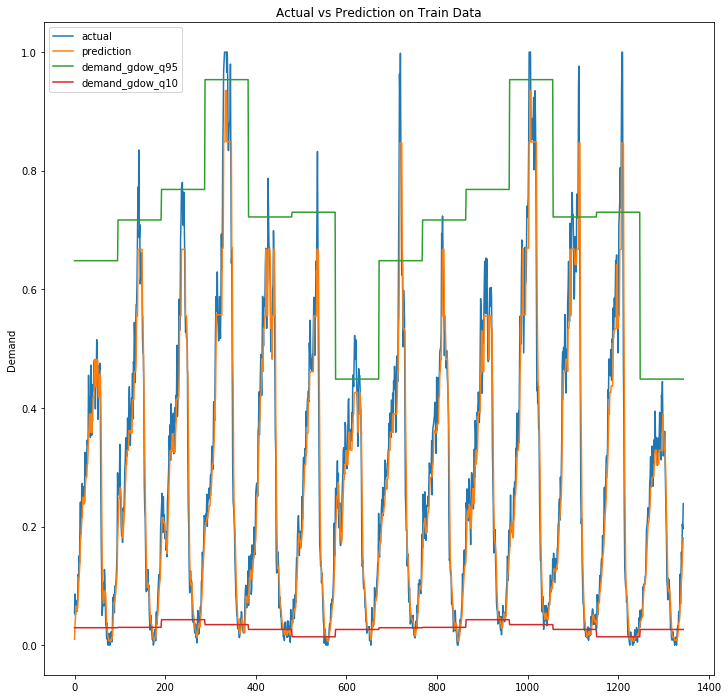

In [30]:
f, ax = plt.subplots(figsize=(12,12))
_d = df_train_wt_cluster.loc[_x.index].sort_values(by=['day', 'hour', 'minute'])
x_plot = np.arange(_d.shape[0])
sns.lineplot(
    x_plot,
    _d.demand,
    label='actual'
)
sns.lineplot(
    x_plot,
    _d.y_hat,
    label='prediction'
)
sns.lineplot(
    x_plot,
    np.abs(_d.demand_gdow_q95),
    label='demand_gdow_q95'
)
sns.lineplot(
    x_plot,
    _d.demand_gdow_q10,
    label='demand_gdow_q10'
)
plt.ylabel('Demand')
plt.title('Actual vs Prediction on Train Data')
plt.legend()
plt.show()

In [31]:
df_feature_importances = pd.DataFrame({
    'feature': X_train.columns[np.array(p_cat_tree.steps[1][1].feature_names_).astype(int)],
    'importances': p_cat_tree.steps[1][1].feature_importances_
})
df_feature_importances.sort_values(by='importances', ascending=False)

,feature,importances
19,demand_rolling_4,97.099691
18,cluster_prob_gdowh,2.623897
12,mean_enc_demand_tmin4,0.162559
11,mean_enc_demand_tmin1,0.051558
14,demand_gdow_q95,0.032725
9,mean_demand_per_gdow,0.016148
17,mean_demand_diff_wt_gdow_q10,0.008453
8,median_demand_per_geo,0.004969
16,mean_demand_diff_wt_gdow_q95,0.000000
15,demand_gdow_q10,0.000000


In [32]:
df_err = rmse_per_region(
    X_train['lat'],
    X_train['long'],
    y_train,
    X_train['y_hat']
)
df_err.head()

,lat,long,mse,y_true,rmse,MAPE
0,-5.484924,90.653687,0.000033,0.001644,0.005706,-0.160895
1,-5.484924,90.664673,0.000283,0.010688,0.016831,-1.029487
2,-5.484924,90.675659,0.000004,0.000190,0.002066,-0.018597
3,-5.484924,90.686646,0.000091,0.003899,0.009522,-0.379349
4,-5.484924,90.697632,0.000133,0.006419,0.011530,-0.624596


In [34]:
df_err.describe()

,lat,long,mse,y_true,rmse,MAPE
count,1307.000000,1307.000000,1.307000e+03,1307.000000,1307.000000,1307.000000
mean,-5.350718,90.785842,4.616152e-04,0.054309,0.015485,-4.455608
std,0.065613,0.107205,9.674412e-04,0.100794,0.014900,6.922584
min,-5.484924,90.587769,1.543516e-07,0.000000,0.000393,-46.340226
25%,-5.402527,90.697632,2.789834e-05,0.002560,0.005282,-5.839437
50%,-5.353088,90.785522,1.308026e-04,0.016653,0.011437,-1.622672
75%,-5.298157,90.873413,4.507029e-04,0.062637,0.021230,-0.250985
max,-5.237732,90.972290,9.168426e-03,0.874390,0.095752,0.000255


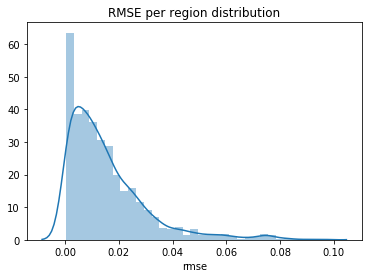

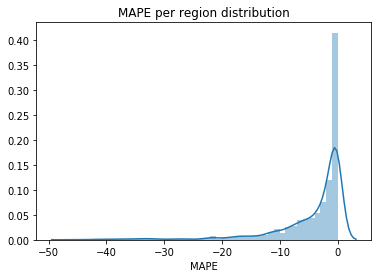

In [33]:
plt.title('RMSE per region distribution')
sns.distplot(df_err.rmse)
plt.show()

plt.title('MAPE per region distribution')
sns.distplot(df_err.MAPE)
plt.show()

In [35]:
X_test = test_set[categorical_features + numerical_features]
y_test = test_set[target]

In [36]:
y_hat = p_cat_tree.predict(X_test)
print_all_metrics(y_test, y_hat)

mape: inf
mape1: 96.64686821319394
rmse: 0.023972585437601036
mae: 0.011157264681797525
r2: 0.9641040553555206
eav: 0.9644612457487801


In [37]:
X_test['y_hat'] = y_hat

/home/arie/miniconda2/envs/data_analysis_351/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
_x = X_test[
        (X_test.lat == lat) &
        (X_test.long == long)
    ]
df_train_wt_cluster.loc[_x.index, 'y_hat'] = _x.y_hat

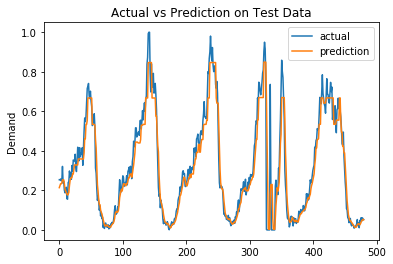

In [39]:
_d = df_train_wt_cluster.loc[_x.index].sort_values(by=['day', 'hour', 'minute'])
x_plot = np.arange(_d.shape[0])
sns.lineplot(
    x_plot,
    _d.demand,
    label='actual'
)
sns.lineplot(
    x_plot,
    _d.y_hat,
    label='prediction'
)
plt.ylabel('Demand')
plt.title('Actual vs Prediction on Test Data')
plt.legend()
plt.show()

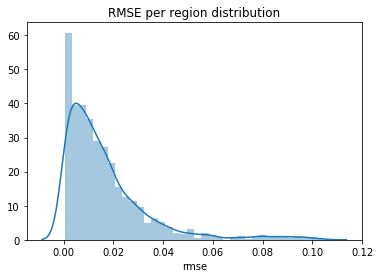

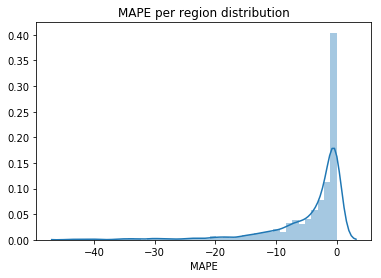

In [40]:
df_err = rmse_per_region(
    X_test['lat'],
    X_test['long'],
    y_test,
    X_test['y_hat']
)

plt.title('RMSE per region distribution')
sns.distplot(df_err.rmse)
plt.show()

plt.title('MAPE per region distribution')
sns.distplot(df_err.MAPE)
plt.show()

I have presented my model to predict current time demand, now I need to extend my prediction to at least $T + 5$, with only using about 14 days to predict.

# Predicting the Future

In [62]:
temp_features = ['day', 'hour', 'minute']
temp = df_train.groupby('geohash6')[temp_features + ['demand']].apply(lambda x: x.sort_values(by=temp_features, ascending=False).head(1))

In [85]:
temp_arr = temp.reset_index().set_index('geohash6')[temp_features].apply(lambda x: get_future_n_ticks(*x,5), axis=1)

In [108]:
rows=[]
temp_arr.reset_index().apply(lambda r: [rows.append([r.geohash6] + list(t)) for t in r[0]], axis=1)

0       [None, None, None, None, None]
1       [None, None, None, None, None]
2       [None, None, None, None, None]
3       [None, None, None, None, None]
4       [None, None, None, None, None]
5       [None, None, None, None, None]
6       [None, None, None, None, None]
7       [None, None, None, None, None]
8       [None, None, None, None, None]
9       [None, None, None, None, None]
10      [None, None, None, None, None]
11      [None, None, None, None, None]
12      [None, None, None, None, None]
13      [None, None, None, None, None]
14      [None, None, None, None, None]
15      [None, None, None, None, None]
16      [None, None, None, None, None]
17      [None, None, None, None, None]
18      [None, None, None, None, None]
19      [None, None, None, None, None]
20      [None, None, None, None, None]
21      [None, None, None, None, None]
22      [None, None, None, None, None]
23      [None, None, None, None, None]
24      [None, None, None, None, None]
25      [None, None, None

In [109]:
pd.DataFrame(rows)

,0,1,2,3
0,qp02yc,20,0,0
1,qp02yc,20,0,15
2,qp02yc,20,0,30
3,qp02yc,20,0,45
4,qp02yc,20,1,0
5,qp02yf,20,0,0
6,qp02yf,20,0,15
7,qp02yf,20,0,30
8,qp02yf,20,0,45
9,qp02yf,20,1,0
